In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import itertools
from evaluation import *
from data_loader import *
import random
from datetime import datetime
import numpy as np
from datetime import timedelta

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "CMA-ES": 'cyan',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
experiments = list(itertools.chain(
    range(4000, 4180),
    range(5000, 5180),
    range(6000, 6180),
))
target_agg_count = 10

exp_power_data = []

for ind, exp_num in enumerate(experiments):
    config_fname = f'./Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']

    if algo_c == 'ODT':
        target_agg_count = 4
    
    env_c = c['environment_settings']
    eval_c = c['eval_config']

    # if federated_c['aggregation_count'] != target_agg_count and target_agg_count != None:
    #     print(f"Experiment {exp_num} does not have matching aggregation level")
    #     continue
    
    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/"

    print(f'Loading {base_path}power_and_co2_metrics.csv')
    power_data = load_from_json_with_error_handling(f'{base_path}power_and_co2_metrics.csv', ['time', 'power', 'co2'])
    
    power_data['seed'] = seed
    power_data['exp_num'] = exp_num
    
    power_data['algorithm'] = algorithm_dm
    power_data['season'] = env_c['season']
    power_data['num_aggs'] = federated_c['aggregation_count']
    power_data['eps_per_agg'] = nn_c['num_episodes']

    exp_power_data.append(power_data)

Loading ../../../../storage_1/metrics/Exp_4000/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4001/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4002/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4003/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4004/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4005/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4006/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4007/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4008/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4009/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4010/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4011/train/power_and_co2_metrics.csv
Loading ../../../../storage_1/metrics/Exp_4012/train

In [4]:
# Convert data to DataFrame for easier manipulation
df_power = pd.concat(exp_power_data, ignore_index=True)

df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg
0,2025-03-21 19:42:02,29.3,0.000449,1234,4000,DQN,spring,50,200
1,2025-03-21 19:45:33,27.7,0.000449,1234,4000,DQN,spring,50,200
2,2025-03-21 19:49:04,27.8,0.000449,1234,4000,DQN,spring,50,200
3,2025-03-21 19:52:35,27.9,0.000449,1234,4000,DQN,spring,50,200
4,2025-03-21 19:56:06,27.9,0.000449,1234,4000,DQN,spring,50,200


In [5]:
# Calculate cumulative power for each experiment and add it as a new column
df_power['cumulative_power'] = df_power.groupby('exp_num')['power'].cumsum()

df_power['time'] = pd.to_datetime(df_power['time'], errors='coerce')
df_power['time'] = df_power.groupby('exp_num')['time'].transform(lambda x: (x - x.min()).dt.total_seconds())

df_power['co2'] = df_power['co2'] * 1000 # Convert to grams

# Convert 3 aggs to 1 for CMA
df_power['num_aggs'] = np.where(
    (df_power['num_aggs'] == 3) & 
    (df_power['algorithm'] == 'CMA'), 
    1, 
    df_power['num_aggs']
)

# Display the first few rows of the updated DataFrame
df_power.head()

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_power
0,0.0,29.3,0.449398,1234,4000,DQN,spring,50,200,29.3
1,211.0,27.7,0.449398,1234,4000,DQN,spring,50,200,57.0
2,422.0,27.8,0.449398,1234,4000,DQN,spring,50,200,84.8
3,633.0,27.9,0.449398,1234,4000,DQN,spring,50,200,112.7
4,844.0,27.9,0.449398,1234,4000,DQN,spring,50,200,140.6


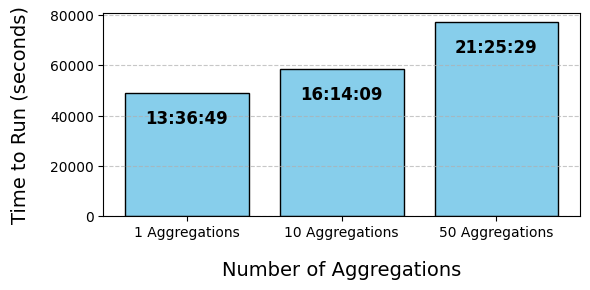

In [6]:
# Display average time to completion for each aggregation level
final_times = df_power.groupby('exp_num')['time'].max().reset_index()
final_times.rename(columns={'time': 'final_time'}, inplace=True)

final_times = final_times.merge(df_power[['exp_num', 'num_aggs']].drop_duplicates(), on='exp_num')

average_final_time = final_times.groupby('num_aggs')['final_time'].mean().reset_index()

average_final_time['agg_label'] = average_final_time['num_aggs'].apply(lambda x: f"{x} Aggregations")

def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(secs):02}"

plt.figure(figsize=(6, 3))
bars = plt.bar(average_final_time['agg_label'], average_final_time['final_time'], 
               color='skyblue', edgecolor='black')
#plt.title('Average Final Time by Number of Aggregations', fontsize=18, pad=15)
plt.ylabel('Time to Run (seconds)', fontsize=14, labelpad=15)
plt.xlabel('Number of Aggregations', fontsize=14, labelpad=15)
for bar in bars:
    height = bar.get_height()
    hms = seconds_to_hms(height)
    plt.annotate(hms,
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, -25),  # 5 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

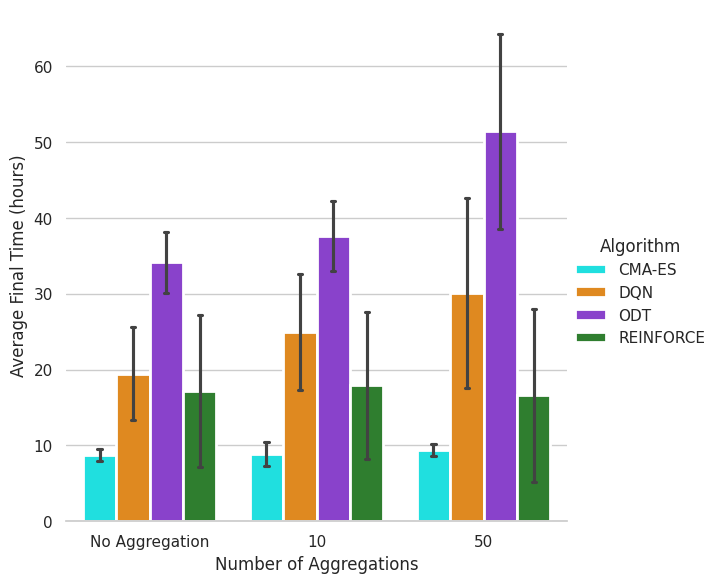

,time,power,co2,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_power
1472,0.0,34.8,0.651213,1234,4003,DQN,spring,10,1000,34.8
1473,265.0,34.9,0.651213,1234,4003,DQN,spring,10,1000,69.7
1474,530.0,35.0,0.651213,1234,4003,DQN,spring,10,1000,104.7
1475,795.0,35.3,0.651213,1234,4003,DQN,spring,10,1000,140.0
1476,1060.0,35.3,0.651213,1234,4003,DQN,spring,10,1000,175.3


In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Compute the final time per experiment
final_times = df_power.groupby(['exp_num', 'num_aggs', 'algorithm'])['time'].max().reset_index()

# Convert 'num_aggs' to a categorical variable if it's not already
final_times['num_aggs'] = final_times['num_aggs'].astype(str)
final_times['time'] = final_times['time'] / 3600  # Convert seconds to hours
final_times['algorithm'] = final_times['algorithm'].replace('CMA', 'CMA-ES')

mean_dqn = final_times.loc[final_times['algorithm'] == 'DQN', 'time'].mean()
mask_odt = final_times['algorithm'] == 'ODT'
final_times.loc[mask_odt, 'time'] += mean_dqn

final_times['num_aggs_str'] = final_times['num_aggs'].astype(str)
final_times['num_aggs_label'] = final_times['num_aggs_str'].replace({'1': 'No Aggregation'})

sorted_aggs = sorted(final_times['num_aggs_str'].unique(), key=int)
agg_labels_ordered = ['No Aggregation' if a=='1' else a for a in sorted_aggs]

algorithms = sorted(final_times['algorithm'].unique())


# Create the bar plot with standard deviation error bars
# g = sns.catplot(
#     data=final_times,
#     kind="bar",
#     x="num_aggs",
#     y="time",
#     hue="algorithm",
#     errorbar="sd",
#     palette=colors,
#     alpha=1,
#     height=6,
#     capsize=0.1,
#     linewidth=2
# )

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=final_times,
    kind="bar",
    x="num_aggs_label",
    y="time",
    hue="algorithm",
    order=agg_labels_ordered,
    hue_order=algorithms,
    errorbar="sd",
    palette=colors,
    alpha=1,
    height=6,
    capsize=0.1,
    linewidth=2
)

# Customize the plot
g.despine(left=True)
g.set_axis_labels("Number of Aggregations", "Average Final Time (hours)")
g.legend.set_title("Algorithm")

plt.savefig('./Figures/training_durations.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Remove non-target data
df_power = df_power[df_power['num_aggs'] == target_agg_count]

df_power.head()

In [8]:
# Filter the final_times DataFrame for num_aggs == '6'
agg_6 = final_times[final_times['num_aggs'] == '10'].copy()

# Convert 'time' from seconds to hours
agg_6['time_hours'] = agg_6['time'] / 3600  # 3600 seconds in an hour

# Group by 'algorithm' and calculate mean and standard deviation of 'time_hours'
stats = agg_6.groupby('algorithm')['time_hours'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
stats.rename(columns={'mean': 'Mean Training Time (hours)', 'std': 'Std Dev (hours)'}, inplace=True)

# Print the results
print("\nMean and Standard Deviation of Training Time by Algorithm (num_aggs == 6):")
print(stats.to_string(index=False))


Mean and Standard Deviation of Training Time by Algorithm (num_aggs == 6):
algorithm  Mean Training Time (hours)  Std Dev (hours)
   CMA-ES                    0.002463         0.000438
      DQN                    0.006929         0.002119
      ODT                    0.010455         0.001272
REINFORCE                    0.004977         0.002696


In [9]:
# Function to calculate energy in kWh for a single experiment
def calculate_energy_kWh(exp_data):
    # Sort the data by elapsed time
    exp_data_sorted = exp_data.sort_values('time')
    
    # Extract power (W) and time (s)
    power = exp_data_sorted['power'].values  # Power in W
    time_sec = exp_data_sorted['time'].values  # Time in seconds
    
    # Convert time to hours for integration
    time_hours = time_sec / 3600  # Convert seconds to hours
    
    # Handle cases where time_hours may not be strictly increasing
    # Ensure that time_hours is sorted and unique
    if not np.all(np.diff(time_hours) >= 0):
        raise ValueError("Time data must be sorted and non-decreasing for integration.")
    
    # Integrate power over time using the trapezoidal rule to get energy in Wh
    energy_Wh = np.trapz(power, time_hours)  # Integration: ∫ P(t) dt
    
    # Convert Wh to kWh
    energy_kWh = energy_Wh / 1000
    
    return energy_kWh

# Iterate over each unique algorithm in the DataFrame
for algo in df_power['algorithm'].unique():
    # Filter data for the current algorithm
    algo_data = df_power[df_power['algorithm'] == algo]
    
    # Group by 'exp_num' to process each experiment separately
    grouped = algo_data.groupby('exp_num')
    
    # Initialize lists to store energy and CO2 for each experiment
    energy_kWh_list = []
    co2_list = []
    
    # Iterate over each experiment within the algorithm
    for exp_num, exp_data in grouped:
        try:
            # Calculate energy in kWh for the experiment
            energy_kWh = calculate_energy_kWh(exp_data)
            energy_kWh_list.append(energy_kWh)
            
            # Assume 'co2' is recorded at each time point; take the last entry as total CO2
            co2_total = exp_data['co2'].iloc[-1]
            co2_list.append(co2_total)
        except ValueError as e:
            print(f"Error processing Algorithm {algo}, Experiment {exp_num}: {e}")
    
    # Convert lists to NumPy arrays for statistical calculations
    energy_kWh_array = np.array(energy_kWh_list)
    co2_array = np.array(co2_list)
    
    # Calculate mean and standard deviation for energy
    avg_energy_kWh = energy_kWh_array.mean()
    std_energy_kWh = energy_kWh_array.std()
    
    # Calculate mean and standard deviation for CO2 emissions
    avg_co2 = co2_array.mean()
    std_co2 = co2_array.std()
    
    # Print the metrics with updated units
    print(f"Algorithm {algo} Power and CO2 Metrics")
    print(f"\tAverage energy used per experiment: {avg_energy_kWh:.4f} kWh")
    print(f"\tStandard deviation of energy used per experiment: {std_energy_kWh:.4f} kWh")
    print(f"\tAverage CO2 estimated emissions per experiment: {avg_co2:.4f} g")
    print(f"\tStandard deviation of CO2 estimated emissions per experiment: {std_co2:.4f} g\n")

Algorithm DQN Power and CO2 Metrics
	Average energy used per experiment: 0.8790 kWh
	Standard deviation of energy used per experiment: 0.2498 kWh
	Average CO2 estimated emissions per experiment: 0.4407 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1250 g

Algorithm REINFORCE Power and CO2 Metrics
	Average energy used per experiment: 0.6062 kWh
	Standard deviation of energy used per experiment: 0.3339 kWh
	Average CO2 estimated emissions per experiment: 0.3510 g
	Standard deviation of CO2 estimated emissions per experiment: 0.1227 g

Algorithm CMA Power and CO2 Metrics
	Average energy used per experiment: 0.3798 kWh
	Standard deviation of energy used per experiment: 0.0747 kWh
	Average CO2 estimated emissions per experiment: 0.1951 g
	Standard deviation of CO2 estimated emissions per experiment: 0.0251 g

Algorithm ODT Power and CO2 Metrics
	Average energy used per experiment: 4.4496 kWh
	Standard deviation of energy used per experiment: 2.5143 kWh
	Average CO2 esti

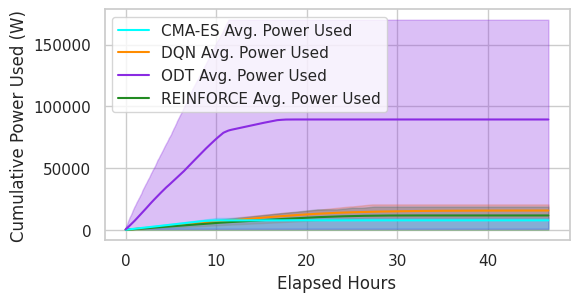

In [10]:
plt.figure(figsize=(6, 3))

t_min = df_power['time'].min()
t_max = df_power['time'].max()
time_grid = np.linspace(t_min, t_max, num=1000)  # Adjust num as needed

for algo in df_power['algorithm'].unique():
    algo_data = df_power[df_power['algorithm'] == algo]

    # Get list of experiments/runs
    experiments = algo_data['exp_num'].unique()

    # List to store interpolated cumulative_power values for each experiment
    interp_cumulative_powers = []

    for exp in experiments:
        exp_data = algo_data[algo_data['exp_num'] == exp]

        # Sort data by time
        exp_data = exp_data.sort_values('time')

        # Extract time and cumulative_power values
        exp_time = exp_data['time'].values
        exp_cum_power = exp_data['cumulative_power'].values

        # Get the maximum cumulative_power for this experiment
        max_cum_power = exp_cum_power[-1]

        # Interpolate cumulative_power over the common time grid
        # Cap the values beyond the last time point
        interp_cumulative_power = np.interp(
            time_grid,
            exp_time,
            exp_cum_power,
            left=0,  # Assuming cumulative_power is zero before the experiment starts
            right=max_cum_power  # Cap cumulative_power at max_cum_power after experiment ends
        )

        interp_cumulative_powers.append(interp_cumulative_power)

    # Convert list to numpy array for easy computation
    interp_cumulative_powers = np.array(interp_cumulative_powers)

    # Compute min, max, mean at each time point
    min_cumulative_power = np.min(interp_cumulative_powers, axis=0)
    max_cumulative_power = np.max(interp_cumulative_powers, axis=0)
    mean_cumulative_power = np.mean(interp_cumulative_powers, axis=0)

    # Convert time from seconds to hours
    time_grid_hours = time_grid / 3600.0

    # Plotting
    plt.fill_between(
        time_grid_hours, 
        min_cumulative_power, 
        max_cumulative_power,
        color=colors[algo],
        alpha=0.3
    )
    algo_name = algo
    if algo_name == 'CMA':
        algo_name = 'CMA-ES'
    plt.plot(
        time_grid_hours, 
        mean_cumulative_power,
        color=colors[algo],
        label=f'{algo_name} Avg. Power Used'
    )

# then before saving/showing:
handles, labels = plt.gca().get_legend_handles_labels()
# sort by label string
labels_handles = sorted(zip(labels, handles), key=lambda x: x[0])
labels_sorted, handles_sorted = zip(*labels_handles)

plt.legend(handles_sorted, labels_sorted, loc='upper left')

plt.xlabel('Elapsed Hours')
plt.ylabel('Cumulative Power Used (W)')
#plt.title('Cumulative Power Used During Training')
plt.grid(True)

plt.savefig('./Figures/power_used.png', dpi=300, bbox_inches='tight')

plt.show()